In [1]:
import SiemensQuadraProperties as sqp
from ActivityTools import *
from SimulationDataset import *

from multiprocessing import Pool
import random
import numpy as np
import matplotlib.pyplot as mpl
myColours=[]
for colour in mpl.cm.viridis( np.linspace( 0.05, 0.8, 4 ) ):
    myColours.append( colour )
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=myColours)

params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "lower right",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
mpl.rcParams.update(params)

The NEMU NU 2-2012 calculation for variation of NECR with source activity, although now we are only interested in the maximum value

In [2]:
def NECRatTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 20E6, timeSec )

        necr, true, rPlusS = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

def NECRatTimeZr89( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, simulationWindow=1E-3, coincidenceWindow=4.7E-9 ):

    # NEMU NU 2-2012 says 650mm window for 700mm phantom, so keep the same relation
    zWindow = (phantomLength - 50) / 2
    
    # get volume in cc
    phantomRadius = 20.3 / 2.0
    phantomVolume = phantomRadius * phantomRadius * math.pi * phantomLength / 10.0 # assume length in mm
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    for time in range( 0, 28000, 800 ): #Zr89 half life roughly 40x longer than F18
        timeSec = float(time) * 60.0
        activity = Zr89ActivityAtTime( 20E6, timeSec )

        necr, true, rPlusS = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity / phantomVolume )
    
    mpl.clf()
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime

WARNING: this calculation will take a long time

We choose a range of test detector lengths (the real lengths are calculated using discrete detector component sizes) and for each one find the peak NECR value with a given source. We then repeat for a range of different source isotopes. This requires a large amount of simulation and calculation of the decay coincidences.

Both the simulation window size and the dataset size will have a significant impact on the total calculation time. Existing datasets will be re-used automatically (mitigating this issue somewhat) and the simulation window has the greatest effect on statistical fluctuation in the result (10ms window recommended, but this will be slow)

Although the simulation and the coincidence calculation are single-threaded, they can be run completely in parallel. A simple multiprocessing model gives close to ideal scaling - 10 processes are used by default, but adjust this to suit your system

In [9]:
# Investigate ideal detector length with Siemens geometry
def OneDetector( detectorLength, phantomLength, isotope, simulationWindow=1E-2, coincidenceWindow=4.7E-9 ):
    
    tracerName = "Linear" + isotope
    isotopeMethod = NECRatTimeF18
    if isotope == "Zr89":
        isotopeMethod = NECRatTimeZr89
    
    # Fix random seed for reproducibility, don't if you want variation
    # Has to be set in this method, not before, because this is where we enter the worker processes
    random.seed( detectorLength )
    
    tracerData = CreateDataset( detectorLength, "Siemens", phantomLength, tracerName, 1000000, 435.0, 585.0, CoincidenceWindow=coincidenceWindow )
    crystalData = CreateDataset( detectorLength, "Siemens", phantomLength, "Siemens", 1000000, 435.0, 585.0, CoincidenceWindow=coincidenceWindow )
    crystalActivity = sqp.Lu176decaysInMass( sqp.DetectorMassLength( detectorLength ) )

    activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens = isotopeMethod( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, simulationWindow, coincidenceWindow )

    return ( max( necrAtTimeSiemens ), sqp.DetectorDiscreteLength( detectorLength ) )

def PeakNECRWithLengthMultiprocess( phantomLength, isotope, simulationWindow=1E-2, coincidenceWindow=4.7E-9, processes=10 ):
    
    # Create the arguments for each process
    detectorLengths = [ 100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900 ]
    arguments = []
    for detectorLength in detectorLengths:
        arguments.append( ( detectorLength, phantomLength, isotope, simulationWindow, coincidenceWindow ) )
    
    # Launch a separate process for each detector length
    result = None
    with Pool( processes=processes ) as p:
        result = p.starmap( OneDetector, arguments )
    
    # Unpack the results
    realLengths = []
    maxNECR = []
    for entry in result:
        maxNECR.append( entry[0] )
        realLengths.append( entry[1] )
    return realLengths, maxNECR

detectorLengths = []
maxNECRlines = []
isotopes = [ "F18", "Zr89" ]
for isotope in isotopes:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( 700, isotope, simulationWindow=1E-2 )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation
Re-using previous simulation


Re-using previous simulation





64789.0 events loaded (1000000 simulated) with average 1.0184290543147756 hits/event
Re-using previous simulation
153183.0 events loaded (1000000 simulated) with average 1.0487390898467845 hits/event
Re-using previous simulation
106276.0 events loaded (1000000 simulated) with average 1.0058903233091196 hits/event
227364.0 events loaded (1000000 simulated) with average 1.0797311799581288 hits/event
106817.0 events loaded (1000000 simulated) with average 1.0066468820506098 hits/event
Re-using previous simulation
284661.0 events loaded (1000000 simulated) with average 1.1098288841815351 hits/event
Re-using previous simulation
361780.0 events loaded (1000000 simulated) with average 1.153142793963182 hits/

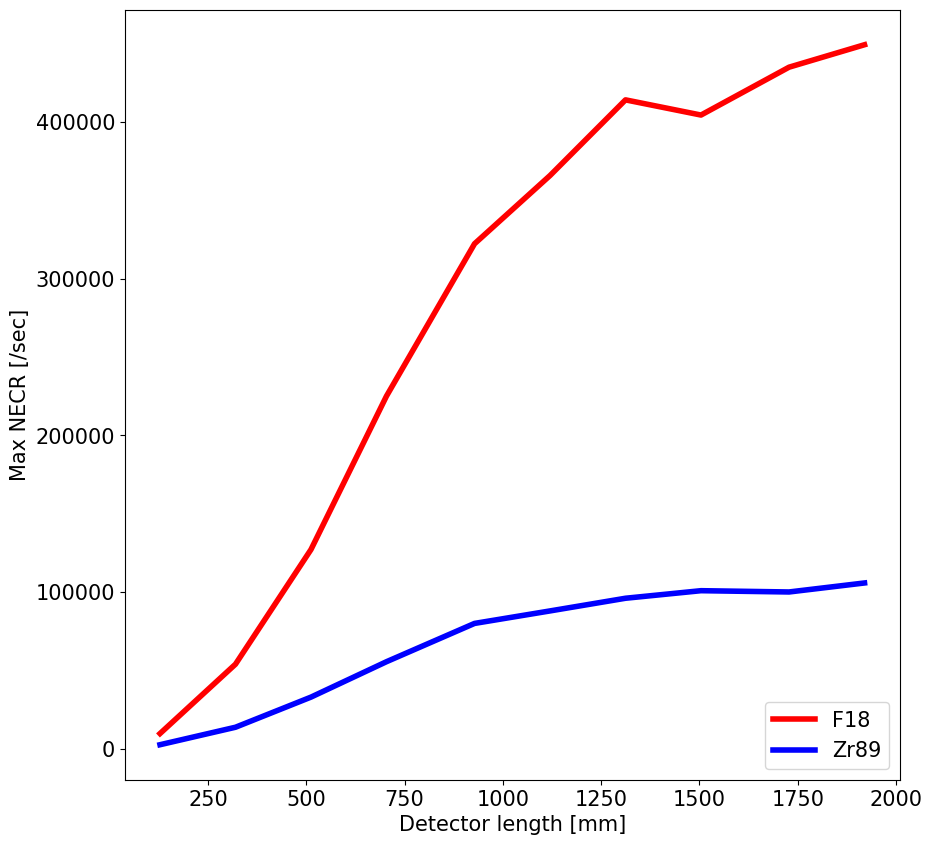

In [10]:
mpl.plot( detectorLengths, maxNECRlines[0], label=isotope[0], color='r', linewidth=4.0 )
mpl.plot( detectorLengths, maxNECRlines[1], label=isotope[1], color='b', linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( isotopes )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

You can see the max NECR value for F18 has a similar trend at ~4x the value for Zr89. This is expected given only 23% of Zr89 decays emit a positron https://www.mdpi.com/1422-0067/21/12/4309

Yoon JK, Park BN, Ryu EK, An YS, Lee SJ. Current perspectives on 89Zr-PET imaging. International Journal of Molecular Sciences. 2020 Jan;21(12):4309.

Repeat the F18 study of NECR variation with detector and source lengths, but for Zr89

In [5]:
detectorLengths = []
maxNECRlines = []
trialPhantoms = [ 300, 700, 1100, 1500 ]
for phantomLength in trialPhantoms:
    detectorLengths, maxNECR = PeakNECRWithLengthMultiprocess( phantomLength, "Zr89", simulationWindow=1E-2 )
    maxNECRlines.append( maxNECR )

Re-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulationRe-using previous simulation
Re-using previous simulation








29864.0 events loaded (1000000 simulated) with average 1.0349919635681757 hits/event
Re-using previous simulation
68528.0 events loaded (1000000 simulated) with average 1.083163086621527 hits/event
98770.0 events loaded (1000000 simulated) with average 1.115126050420168 hits/event
Re-using previous simulation
Re-using previous simulation
121952.0 events loaded (1000000 simulated) with average 1.1346267383888744 hits/event
Re-using previous simulation
141205.0 events loaded (1000000 simulated) with average 1.1486703728621508 hits/event
Re-using previous simulation
167972.0 events loaded (1000000 simulated) with average 1.1616757554830568 hits/event
173835.0 events loaded (1000000 simulated) with averag

106335.0 events loaded (1000000 simulated) with average 1.0058588423378945 hits/event
Re-using previous simulation
141430.0 events loaded (1000000 simulated) with average 1.1236159230714842 hits/event
106933.0 events loaded (1000000 simulated) with average 1.0065835616694565 hits/event
106976.0 events loaded (1000000 simulated) with average 1.0071511367035597 hits/event
Re-using previous simulation
107376.0 events loaded (1000000 simulated) with average 1.0073480107286545 hits/event
107060.0 events loaded (1000000 simulated) with average 1.007612553708201 hits/event
107046.0 events loaded (1000000 simulated) with average 1.0070343590605908 hits/event
107555.0 events loaded (1000000 simulated) with average 1.007084747338571 hits/event
107386.0 events loaded (1000000 simulated) with average 1.0076639412958859 hits/event
107176.0 events loaded (1000000 simulated) with average 1.0074177054564455 hits/event
107221.0 events loaded (1000000 simulated) with average 1.0076477555702708 hits/even

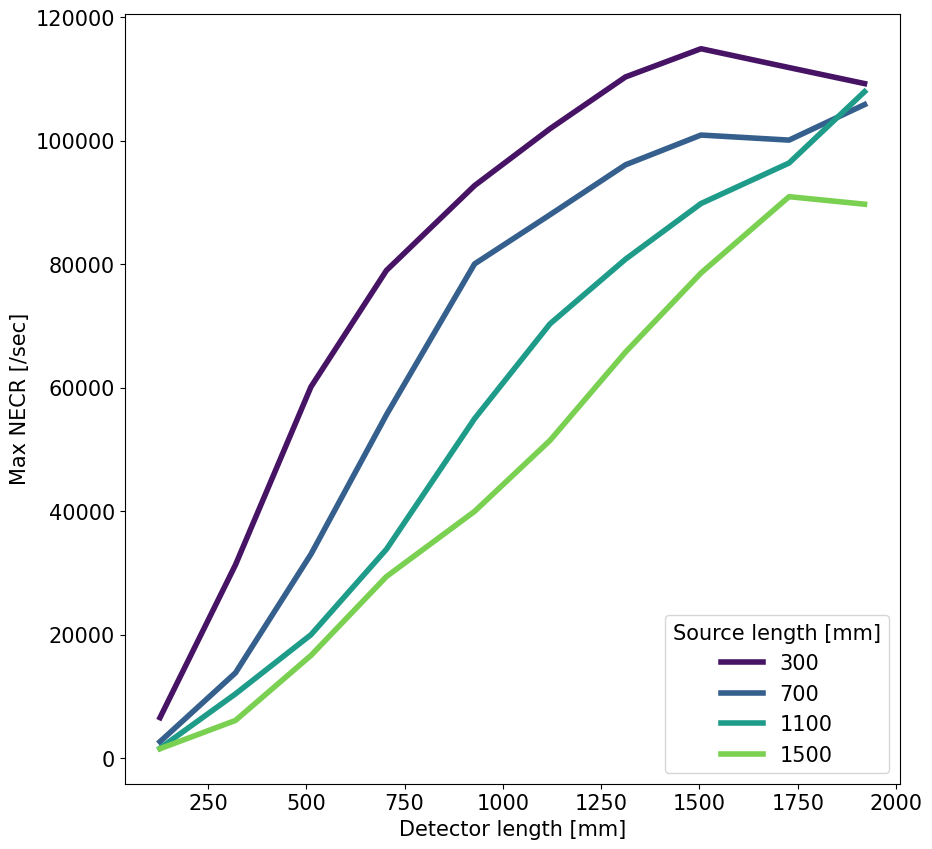

In [6]:
for i, phantomLength in enumerate( trialPhantoms ):
    mpl.plot( detectorLengths, maxNECRlines[i], label=phantomLength, linewidth=4.0 )

mpl.xlabel( "Detector length [mm]" )
mpl.ylabel( "Max NECR [/sec]" )
mpl.legend( trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches( 10, 10 )
mpl.show()

Illustrate the scaling of NECR up to the source length, and beyond

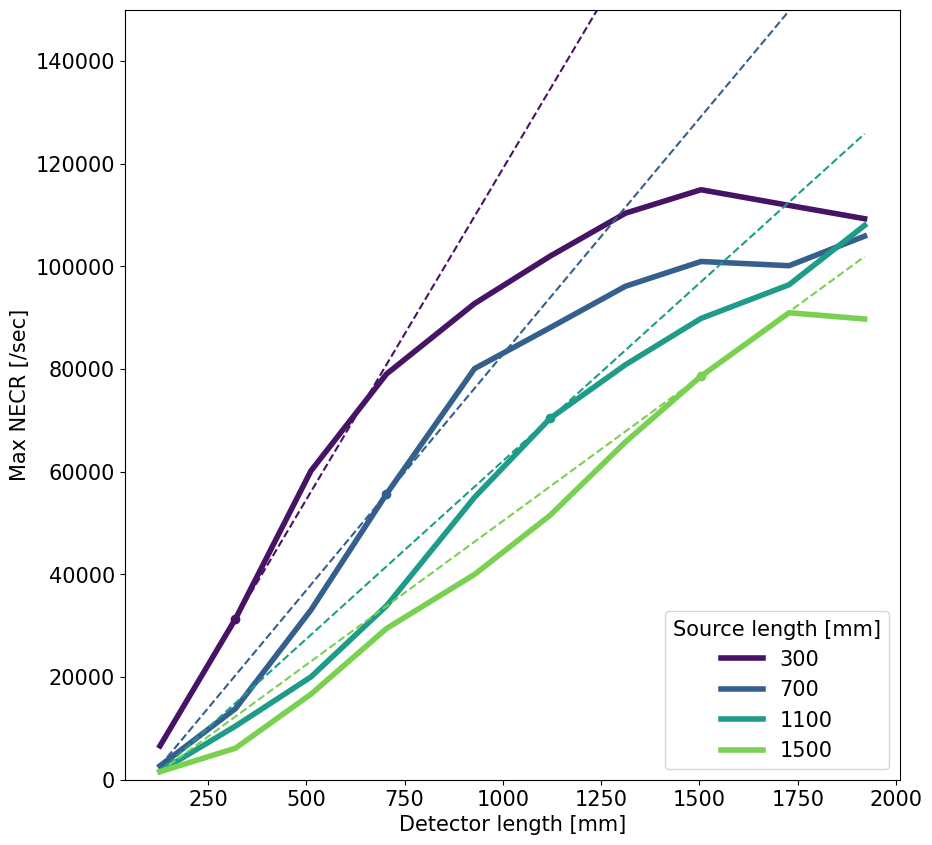

In [7]:
def scale( y0, y1, x1 ):
    m = (y1 - y0) / (x1 - detectorLengths[0])
    y2 = m * ( detectorLengths[-1] - x1 )
    y2 += y1
    return [ y0, y2 ]

def plotThreeParts( xs, ys, i, label, colour ):
    theplot, = mpl.plot( xs, ys, label=label, color=colour, linewidth=4.0 )
    mpl.plot( [xs[0], xs[-1]], scale(ys[0], ys[i], xs[i]), label="_", color=colour, linestyle="dashed" )
    mpl.scatter( [xs[i]], [ys[i]], label="_", color=colour )
    return theplot

legendEntries = []
for i, trialPhantom in enumerate( trialPhantoms ):
    
    # find the detector length index closest to the source length
    detectorLengthIndex = 0
    while detectorLengths[ detectorLengthIndex ] < trialPhantom:
        detectorLengthIndex += 1
    
    theplot = plotThreeParts( detectorLengths, maxNECRlines[i], detectorLengthIndex, trialPhantoms[i], myColours[i] )
    legendEntries.append( theplot )

mpl.xlabel( "Detector length [mm]")
mpl.ylabel( "Max NECR [/sec]")
mpl.legend( legendEntries, trialPhantoms, title="Source length [mm]" )
mpl.gcf().set_size_inches(10,10)
mpl.ylim( [0.0, 1.5e5] )
mpl.show()